In [103]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import  preprocessing
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from qiskit import Aer, QuantumCircuit
from qiskit.algorithms.optimizers import SPSA, COBYLA, GradientDescent
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, ZFeatureMap, PauliFeatureMap
from qiskit.circuit import Parameter
from qiskit.opflow import StateFn, Gradient, I, Z
from qiskit.utils import QuantumInstance

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import CircuitQNN, OpflowQNN
from qiskit_machine_learning.utils.loss_functions import L2Loss, CrossEntropyLoss

In [104]:
df = pd.read_csv('Datasets/Mentor/mock_train_set.csv')
df.head(8)

,0,1,2,3,x
0,2789.26,1000,10,20,0
1,4040.01,1000000,1,1,1
2,2931.20,10000,10000,40,1
3,3896.54,10000,100000,30,1
4,982.06,100,1000,75,0
5,1579.81,1,1000,90,0
6,3031.77,1000000,1000000,35,1
7,860.44,10,100000,60,0


In [105]:
df_test = pd.read_csv('Datasets/Mentor/mock_test_set.csv')
df_test.head(8)

,0,1,2,3,x
0,2988.55,10000,10000,75,1
1,3413.80,1,100,90,0
2,3891.52,1,1,5,0
3,4514.99,10000,1000000,25,1
4,752.29,10,10,90,0
5,1404.13,10000,1000,5,1
6,3390.65,1000000,10000,5,1
7,2620.98,1,10,75,0


In [106]:
f_name_list = list(df)
list(f_name_list)

['0', '1', '2', '3', 'x']

In [107]:
print('Number of empty data in the set: '), df.isnull().sum().sum()
clean_data = df.dropna()

Number of empty data in the set: 


In [108]:
x_org = clean_data.drop('x', axis=1)
cat = clean_data.x

rel = ExtraTreesClassifier()
rel.fit(x_org, cat)

ExtraTreesClassifier()

In [109]:
print(rel.feature_importances_)

[0.13697209 0.48970159 0.27175781 0.10156851]


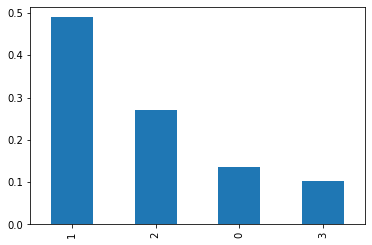

In [110]:
rank_f = pd.Series(rel.feature_importances_, index=x_org.columns)
rank_f.nlargest(20).plot(kind='bar')
plt.show()

In [111]:
corr = clean_data.iloc[:,:-1].corr()
classified = mutual_info_classif(x_org, cat)
class_data = pd.Series(classified, index=x_org.columns)
ordered_f = class_data.sort_values(ascending=False)

In [112]:
ordered_f.head(10)

1    0.326274
2    0.276113
0    0.060894
3    0.039336
dtype: float64

In [113]:
test_ratio = 0.2
seed = 1984
selected_f = clean_data[['0','1','2','3','x']]
selected_test = df_test[['0','1','2','3','x']]

x_train = np.array(selected_f.drop('x', axis =1))
y_train = np.array(selected_f.x)
x = preprocessing.normalize(x_train, axis=0)

x_test = np.array(selected_test.drop('x', axis =1))
y_test = np.array(selected_test.x)
x = preprocessing.normalize(x_test, axis=0)

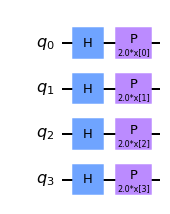

In [114]:
feature_dim = x.shape[1]
emb_layer = 1
ent = 'linear'

fmap = ZFeatureMap(feature_dimension=feature_dim, reps=emb_layer)#, entanglement=ent)
fmap.decompose().draw('mpl', scale=1)

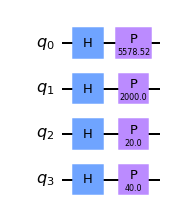

In [115]:
fmap.assign_parameters({k:v for (k,v) in zip(fmap.parameters, x_train[0])}).decompose().draw('mpl', scale=1)

In [116]:
def ansatz_circ(feature_dim, layer, weights):
    ansatz = QuantumCircuit(feature_dim)
    for layer in range(layer):
        for i in range(feature_dim):
            ansatz.ry(weights[i], i)
            #ansatz.rz(weights[i+4], i)
        for i in range(feature_dim - 1):
            ansatz.cx(i, i+1)
        ansatz.cx(3,0)
        ansatz.barrier()
    return ansatz

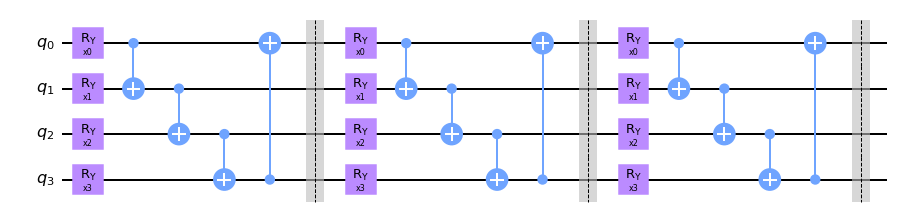

In [117]:
layer = 3
np.random.seed(seed)
nb_w = 4
weights = np.random.random(nb_w)
w_params = [Parameter(f'x{str(i)}') for i in range(nb_w)]

ansatz = ansatz_circ(feature_dim, layer, w_params)
ansatz.draw('mpl')

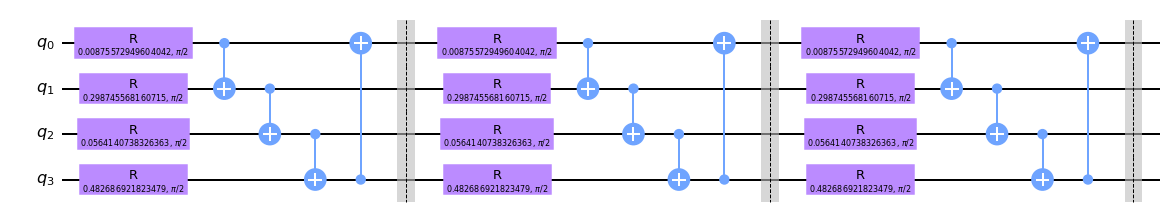

In [118]:
ansatz.assign_parameters({k:v for (k,v) in zip(ansatz.parameters, weights)}).decompose().draw('mpl', scale=1)

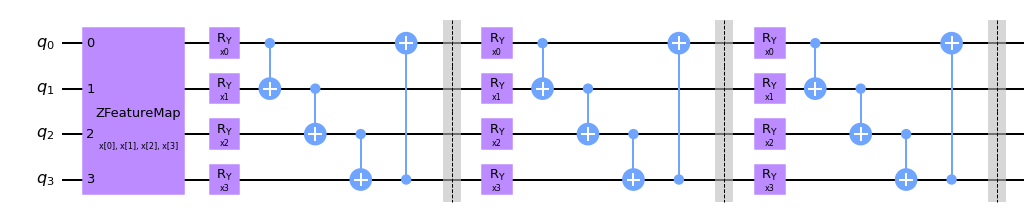

In [119]:
var_circuit = fmap.compose(ansatz)
var_circuit.draw('mpl')

In [120]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [121]:
qasm_sim = Aer.get_backend('aer_simulator')
qinst = QuantumInstance(qasm_sim, 2048, seed_simulator=seed)

In [122]:
num_classes = 2
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [123]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.59521484, 0.40478516]])

In [124]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[ 0.1105957 ,  0.36401367, -0.13916016, -0.08618164],
        [-0.1105957 , -0.36401367,  0.13916016,  0.08618164]]])

In [125]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels))[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

In [126]:
def callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global loss_recorder

    loss_recorder.append(fval)
    print(f'{nfev} - {fval}')

In [127]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
np.random.seed(seed)
initial_point = np.random.random((len(ansatz.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


vqc = vqc.fit(x_train, y_train_1h)

3 - 269.65296118022104
6 - 259.83291213696407
9 - 256.31251669916145
12 - 257.9761826363281
15 - 256.47008265743773
18 - 255.9477990466355
21 - 255.5703110960844
24 - 255.56450026892358
27 - 255.50998541689034
30 - 254.75940871502084
33 - 254.90941401953458
36 - 254.2008634815262
39 - 253.65508422402397
42 - 253.91497636806542
45 - 253.8283195945379
48 - 253.84067690046692
51 - 253.6780114593221
54 - 253.7324120778868
57 - 253.4125127561424
60 - 253.39654084303004
63 - 253.38440237082827
66 - 253.02264665980132
69 - 253.13554262506744
72 - 253.1874414222359
75 - 253.1825374711126
78 - 253.1921159327038
81 - 253.127620359774
84 - 253.28427205347998
87 - 252.94912310558496
90 - 253.009010773199
93 - 253.00188283467003
96 - 253.07850908413565
99 - 253.0129590842531
102 - 252.9903139748419
105 - 253.1387863595465
108 - 253.01697621681288
111 - 253.03029261747807
114 - 253.03191991523698
117 - 252.98198397507215
120 - 253.08289145198614
123 - 252.90714281799256
126 - 252.94301800562533
129 

In [128]:
score_train_1 = vqc.score(x_train, y_train_1h)
score_test_1 = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train_1}')
print(f'Score on the test set {score_test_1}')

Score on the train set 0.7633333333333333
Score on the test set 0.8333333333333334


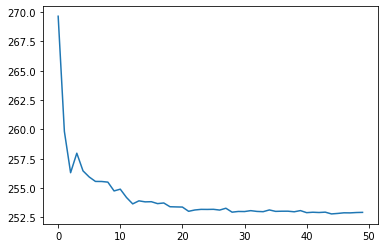

In [129]:
plt.plot(loss_recorder)

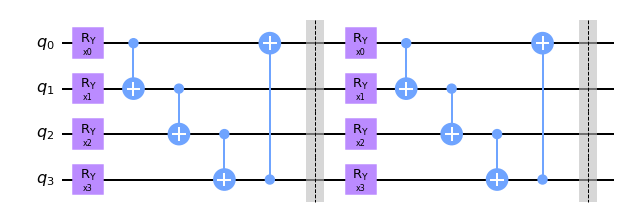

In [130]:
layer = 2
np.random.seed(seed)
weights = np.random.random(nb_w)
w_params = [Parameter(f'x{str(i)}') for i in range(nb_w)]

ansatz = ansatz_circ(feature_dim, layer, w_params)
ansatz.draw('mpl')

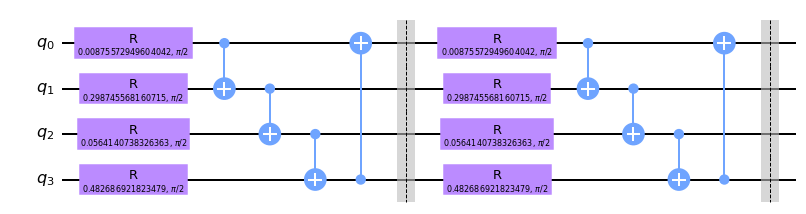

In [131]:
ansatz.assign_parameters({k:v for (k,v) in zip(ansatz.parameters, weights)}).decompose().draw('mpl', scale=1)

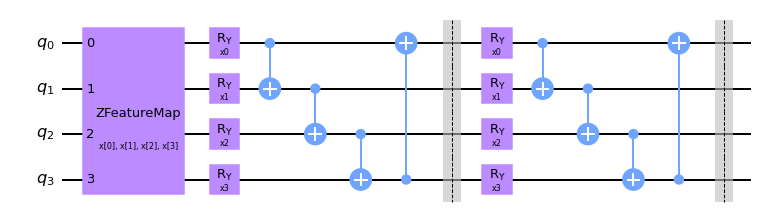

In [132]:
var_circuit = fmap.compose(ansatz)
var_circuit.draw('mpl')

In [133]:
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [134]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.51074219, 0.48925781]])

In [135]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[-0.00317383, -0.02832031,  0.32568359,  0.00708008],
        [ 0.00317383,  0.02832031, -0.32568359, -0.00708008]]])

In [136]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
np.random.seed(seed)
initial_point = np.random.random((len(ansatz.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


vqc = vqc.fit(x_train, y_train_1h)

3 - 318.0772614157695
6 - 307.7187750407178
9 - 321.8245238446194
12 - 302.79260691299737
15 - 306.9987405681927
18 - 305.4577165682217
21 - 306.4625158724744
24 - 300.97321335935516
27 - 300.70398141987107
30 - 301.8022271340758
33 - 300.8784992373628
36 - 300.13232757801416
39 - 299.66941698454355
42 - 299.7675060421465
45 - 299.87504465723055
48 - 299.6870269679573
51 - 299.22010831457163
54 - 299.0516395582751
57 - 299.17165355904126
60 - 299.5820944022797
63 - 299.63516898023045
66 - 301.0383592689321
69 - 299.94274131057824
72 - 299.18491446339874
75 - 299.39386767519363
78 - 299.5951219808129
81 - 299.41622034858676
84 - 299.4085496687452
87 - 299.0364003993483
90 - 298.8308827754821
93 - 298.9559469270936
96 - 299.04512839413667
99 - 298.3197007501768
102 - 298.26634102478886
105 - 298.27997218621476
108 - 298.17298423592
111 - 298.0670099556397
114 - 298.20511295512114
117 - 298.2368359983046
120 - 298.211959691825
123 - 298.21839589765966
126 - 298.01046330510394
129 - 298.11

In [137]:
score_train_2 = vqc.score(x_train, y_train_1h)
score_test_2 = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train_2}')
print(f'Score on the test set {score_test_2}')

Score on the train set 0.5366666666666666
Score on the test set 0.5583333333333333


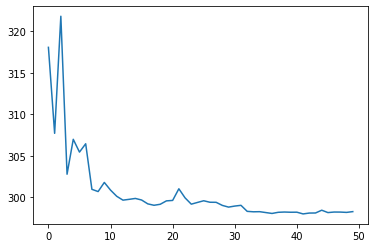

In [138]:
plt.plot(loss_recorder)

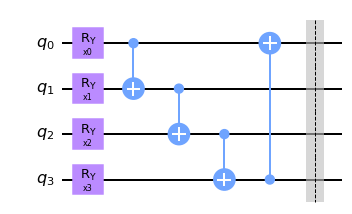

In [139]:
layer = 1
np.random.seed(seed)
weights = np.random.random(nb_w)
w_params = [Parameter(f'x{str(i)}') for i in range(nb_w)]

ansatz = ansatz_circ(feature_dim, layer, w_params)
ansatz.draw('mpl')

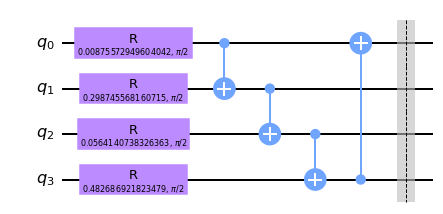

In [140]:
ansatz.assign_parameters({k:v for (k,v) in zip(ansatz.parameters, weights)}).decompose().draw('mpl', scale=1)

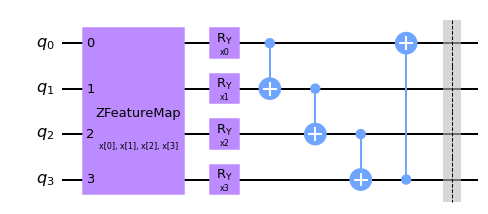

In [141]:
var_circuit = fmap.compose(ansatz)
var_circuit.draw('mpl')

In [142]:
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [143]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.51025391, 0.48974609]])

In [144]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[-0.01025391,  0.00073242, -0.00488281, -0.01367187],
        [ 0.01025391, -0.00073242,  0.00488281,  0.01367187]]])

In [145]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
np.random.seed(seed)
initial_point = np.random.random((len(ansatz.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


vqc = vqc.fit(x_train, y_train_1h)

3 - 300.2799319278664
6 - 300.7276195673214
9 - 305.6682947930319
12 - 294.0036068255883
15 - 296.19337832259436
18 - 295.05446372932784
21 - 294.74279349369306
24 - 293.8376455142024
27 - 293.3036652515266
30 - 293.55711867784294
33 - 293.47239510019097
36 - 293.626294945899
39 - 293.8501188232938
42 - 293.1573425934839
45 - 293.47416451334874
48 - 293.3527032555223
51 - 293.3655483096448
54 - 293.30055406024826
57 - 293.2736687077646
60 - 293.38845300066663
63 - 293.65184966443564
66 - 293.6406230294799
69 - 293.252777878173
72 - 293.4613115280348
75 - 293.4755870962957
78 - 293.4978510918148
81 - 293.46302134526974
84 - 293.3670609614402
87 - 292.9947645590599
90 - 293.44825094421356
93 - 293.3407517440933
96 - 293.4279287254115
99 - 293.2477861361093
102 - 293.18652720725294
105 - 293.3640900863928
108 - 293.59308985596886
111 - 293.49731146067126
114 - 293.3851823539185
117 - 293.264555636297
120 - 293.4582741226209
123 - 293.4605973047056
126 - 293.5321434152314
129 - 293.5921361

In [146]:
score_train_3 = vqc.score(x_train, y_train_1h)
score_test_3 = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train_3}')
print(f'Score on the test set {score_test_3}')

Score on the train set 0.5866666666666667
Score on the test set 0.44166666666666665


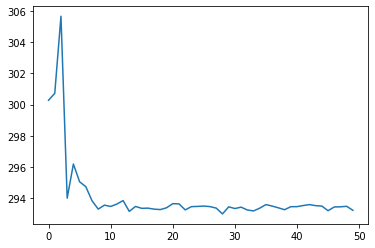

In [147]:
plt.plot(loss_recorder)